In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

import scipy.stats as stat
from scipy.special import rel_entr

from sklearn.model_selection import train_test_split
import time

#MNIST dataset

In [4]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv','rb'),delimiter = ',')
data.shape

(20000, 785)

In [5]:
labels = data[:,0]
data = data[:,1:]

print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


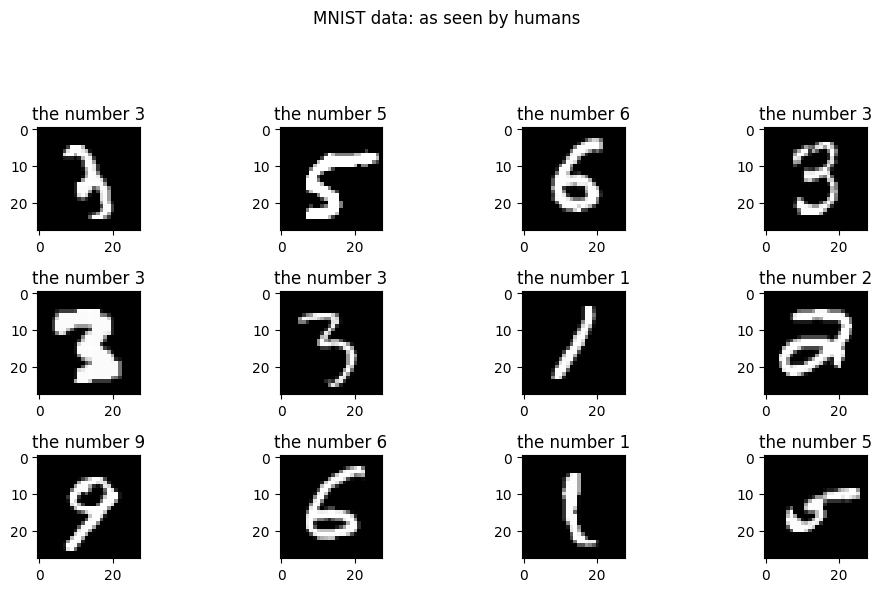

In [6]:
fig, axs = plt.subplots(3,4,figsize = (10,6))

for ax in axs.flatten():
  randimg = np.random.randint(0,high = data.shape[0])

  img = np.reshape(data[randimg,:],(28,28))
  ax.imshow(img,cmap = "gray")

  ax.set_title("the number %i" %labels[randimg])

plt.suptitle("MNIST data: as seen by humans",fontsize = 12)
plt.tight_layout(rect = [0,0,1,.9])

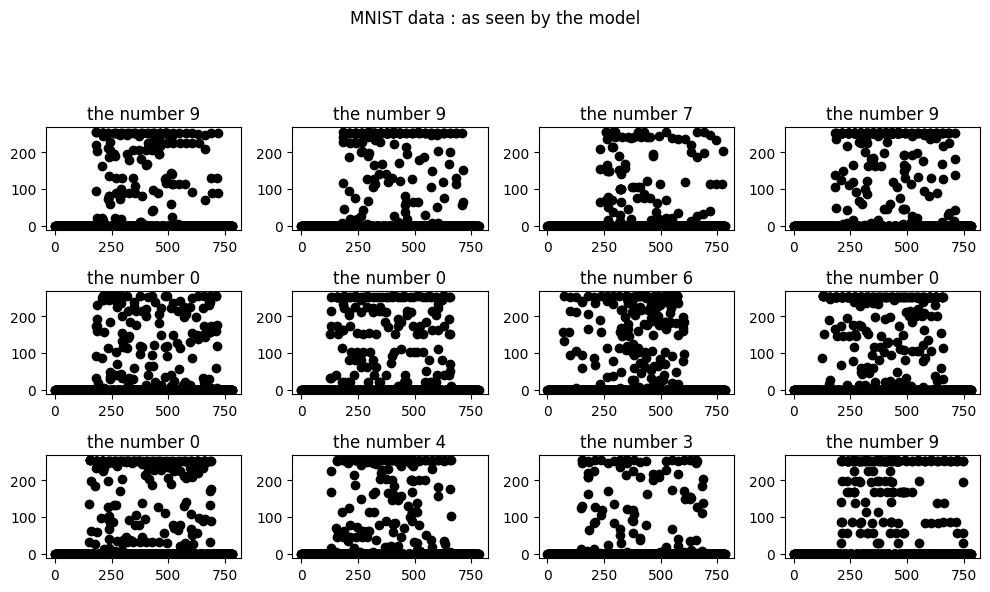

In [7]:
fig, axs = plt.subplots(3,4,figsize = (10,6))

for ax in axs.flatten():
  randimg = np.random.randint(0,high = data.shape[0])

  ax.plot(data[randimg,:],'ko')

  ax.set_title("the number %i" %labels[randimg])

plt.suptitle("MNIST data : as seen by the model",fontsize = 12)
plt.tight_layout(rect = [0,0,1,.9])

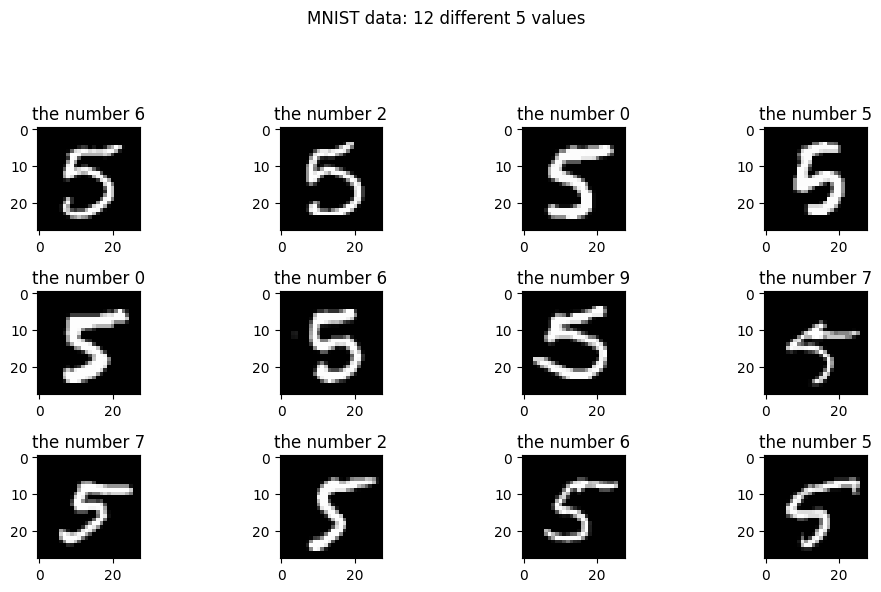

In [8]:
plot_data = data[labels==5][0:12,:]

fig, axs = plt.subplots(3,4,figsize = (10,6))

for i,ax in enumerate(axs.flatten()):
  randimg = np.random.randint(0,high = 12)

  img = np.reshape(plot_data[i,:],(28,28))
  ax.imshow(img,cmap = "gray")

  ax.set_title("the number %i" %labels[randimg])

plt.suptitle("MNIST data: 12 different 5 values",fontsize = 12)
plt.tight_layout(rect = [0,0,1,.9])

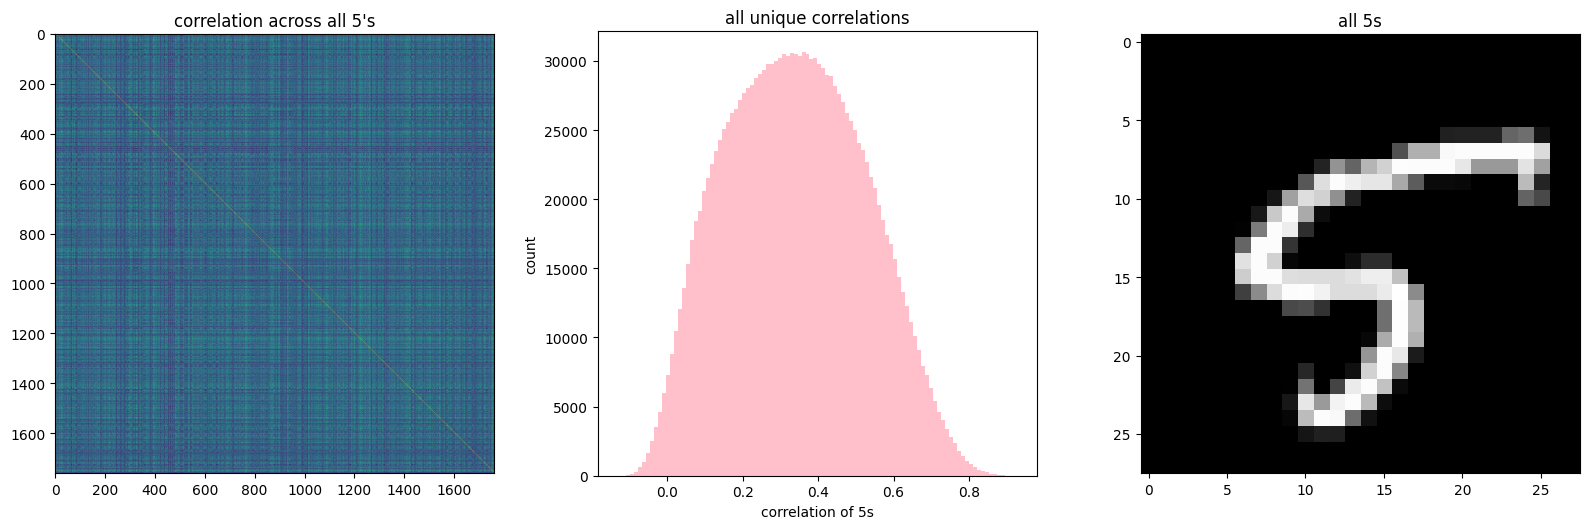

In [9]:
the5s = data[labels==5][0:12,:]
the5s = data[labels==5]

c = np.corrcoef(the5s)

fig,ax = plt.subplots(1,3,figsize = (16,6))
ax[0].imshow(c,vmin=0,vmax = 1)
ax[0].set_title("correlation across all 5's")

uniquecs = np.triu(c,k=1).flatten()
ax[1].hist(uniquecs[uniquecs!=0],bins =100,color = 'pink')
ax[1].set_title("all unique correlations")
ax[1].set_xlabel("correlation of 5s")
ax[1].set_ylabel("count")

ave5s = np.reshape(np.mean(the5s,axis = 0),(28,28))
ax[2].imshow(img,cmap = "gray")
ax[2].set_title("all 5s")
plt.tight_layout(rect = [0,0,1,.9])

#Basic FFN (wo normalization)

In [10]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv','rb'),delimiter = ',')
print(data.shape)

labels = data[:,0]
data = data[:,1:]

print(labels.shape)
print(data.shape)

(20000, 785)
(20000,)
(20000, 784)


In [11]:
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, train_size=0.8)
print(data_train.shape)
print(data_test.shape)
print(labels_train.shape)
print(labels_test.shape)

(16000, 784)
(4000, 784)
(16000,)
(4000,)


In [12]:
data_train_tensor = torch.tensor(data_train).float()
data_test_tensor = torch.tensor(data_test).float()
print(data_train_tensor.shape)

labels_train_tensor = torch.tensor(labels_train).long()
labels_test_tensor = torch.tensor(labels_test).long()
print(labels_train_tensor.shape)

torch.Size([16000, 784])
torch.Size([16000])


In [13]:
mnist_model_1 = nn.Sequential(
    nn.Linear(784,64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,10)
)

lossfun = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(mnist_model_1.parameters(),lr = .01)

print(mnist_model_1)
mnist_model_1(data_train_tensor) #test

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)


tensor([[ 15.4358,  -1.8915,   7.0488,  ...,   4.6255,   1.8257,   8.7916],
        [ 17.3586,   2.2686,   2.8148,  ...,   2.8510,   2.2868,   3.8095],
        [ 17.7825,  -4.5819,   1.2788,  ...,  -5.5296, -11.2371,   4.2886],
        ...,
        [  8.3724,  -6.1730,   2.4908,  ...,   1.4811,   4.0455,   6.5997],
        [ 15.5608,   4.8228,   0.5973,  ...,   2.0366,   0.1657,   1.9144],
        [ 19.6306,   1.8141,  12.3650,  ...,   5.5005,  -3.2777,   7.8187]],
       grad_fn=<AddmmBackward0>)

In [14]:
def training_1 (data_train_tensor,data_test_tensor,\
                labels_train_tensor,labels_test_tensor,\
                model,lossfun,optimizer,numepochs):

  lossTraining = np.zeros(numepochs)
  trainAcc = np.zeros(numepochs)
  testAcc = np.zeros(numepochs)

  for i in range(numepochs):
    yhat = model(data_train_tensor)
    loss = lossfun(yhat,labels_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lossTraining[i] = loss

    trainAcc[i] = torch.mean((torch.argmax(yhat,axis = 1)==labels_train_tensor).float())

    model.eval()
    with torch.no_grad():
      yhat = model(data_test_tensor)
      testAcc[i] = torch.mean((torch.argmax(yhat,axis = 1)==labels_test_tensor).float())

    model.train()


  return trainAcc,testAcc,lossTraining

/tmp/ipython-input-4183283238.py:17: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  lossTraining[i] = loss


test accuracy : 0.8242499828338623


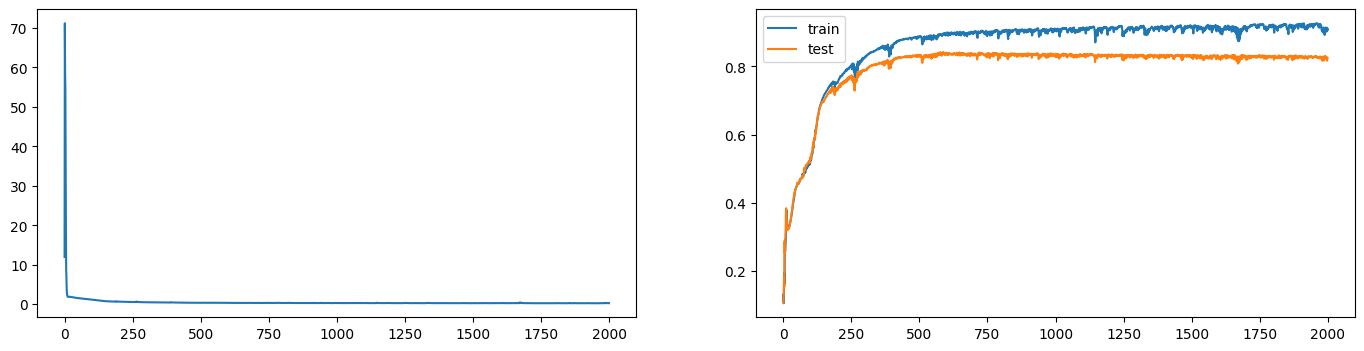

In [15]:
numepochs = 2000
trainAcc,testAcc,lossTraining = training_1 (data_train_tensor,data_test_tensor,\
                                    labels_train_tensor,labels_test_tensor, mnist_model_1,lossfun,optimizer,numepochs)

fig,ax = plt.subplots(1,2, figsize = (17,4))
ax[0].plot(lossTraining)

ax[1].plot(trainAcc)
ax[1].plot(testAcc)
ax[1].legend(["train","test"])

print("test accuracy :", testAcc[-1])

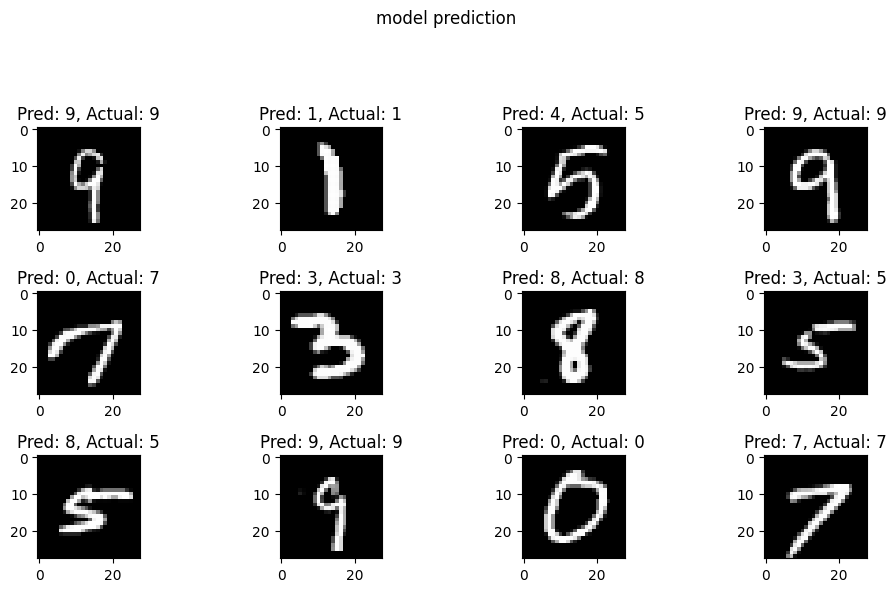

In [16]:
pred = torch.argmax(mnist_model_1(data_test_tensor).detach(),axis = 1)

fig, axs = plt.subplots(3,4,figsize = (10,6))

for i,ax in enumerate(axs.flatten()):
  randimg = np.random.randint(0,high = 12)

  img = np.reshape(data_test_tensor[i,:],(28,28))
  ax.imshow(img,cmap = "gray")

  ax.set_title("Pred: %d, Actual: %d" % (pred[i], labels_test_tensor[i]))

plt.suptitle("model prediction",fontsize = 12)
plt.tight_layout(rect = [0,0,1,.9])

#Basic FFN (w normalization)

In [20]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv','rb'),delimiter = ',')
print(data.shape)

labels = data[:,0]
data = data[:,1:]

print(labels.shape)
print(data.shape)

(20000, 785)
(20000,)
(20000, 784)


In [22]:
data.flatten().shape #2000*784

(15680000,)

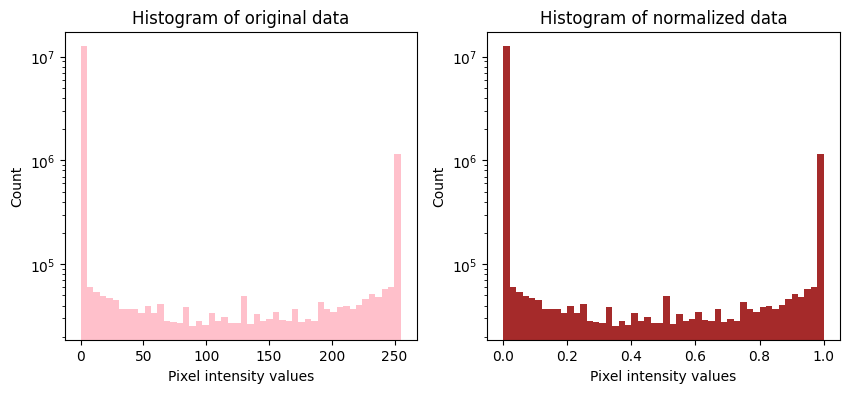

In [33]:
##normalize data
dataNorm = data/np.max(data)

fig,ax = plt.subplots(1,2,figsize = (10,4))
ax[0].hist(data.flatten(),50,color = "pink")
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title("Histogram of original data")
ax[0].set_yscale("log")

ax[1].hist(dataNorm.flatten(),50,color = "brown")
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title("Histogram of normalized data")
ax[1].set_yscale("log")

In [35]:
data_train, data_test, labels_train, labels_test = train_test_split(dataNorm,labels, train_size=0.8)
print(data_train.shape)
print(data_test.shape)
print(labels_train.shape)
print(labels_test.shape)

data_train_tensor = torch.tensor(data_train).float()
data_test_tensor = torch.tensor(data_test).float()
print(data_train_tensor.shape)

labels_train_tensor = torch.tensor(labels_train).long()
labels_test_tensor = torch.tensor(labels_test).long()
print(labels_train_tensor.shape)

(16000, 784)
(4000, 784)
(16000,)
(4000,)
torch.Size([16000, 784])
torch.Size([16000])


test accuracy : 0.859499990940094


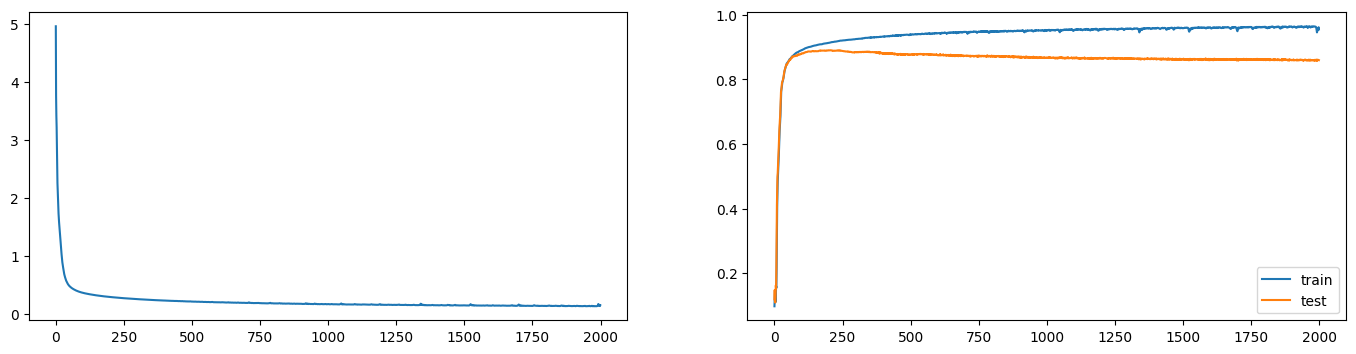

In [36]:
numepochs = 2000
trainAcc,testAcc,lossTraining = training_1 (data_train_tensor,data_test_tensor,\
                                    labels_train_tensor,labels_test_tensor, mnist_model_1,lossfun,optimizer,numepochs)

fig,ax = plt.subplots(1,2, figsize = (17,4))
ax[0].plot(lossTraining)

ax[1].plot(trainAcc)
ax[1].plot(testAcc)
ax[1].legend(["train","test"])

print("test accuracy :", testAcc[-1])


#Batching

In [47]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv','rb'),delimiter = ',')
labels = data[:,0]
data = data[:,1:]

##normalize data
dataNorm = data/np.max(data)

#train-test split
data_train, data_test, labels_train, labels_test = train_test_split(dataNorm,labels, train_size=0.8)

#convert to tensor
data_train_tensor = torch.tensor(data_train).float()
data_test_tensor = torch.tensor(data_test).float()
labels_train_tensor = torch.tensor(labels_train).long() ## long = int64
labels_test_tensor = torch.tensor(labels_test).long() ## long = int64

print(data_train_tensor.shape)
print(labels_train_tensor.shape)

#tensor dataset
train_dataset = TensorDataset(data_train_tensor,labels_train_tensor)
test_dataset = TensorDataset(data_test_tensor,labels_test_tensor)

#dataloader
batchsize = 32
train_loader = DataLoader(train_dataset,batch_size = batchsize, shuffle = True,drop_last = True)
test_loader = DataLoader(test_dataset,batch_size = test_dataset.tensors[0].shape[0])

torch.Size([16000, 784])
torch.Size([16000])


In [48]:
mnist_model_1 = nn.Sequential(
    nn.Linear(784,64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,10)
)

lossfun = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(mnist_model_1.parameters(),lr = .01)

print(mnist_model_1)
mnist_model_1(data_train_tensor) #test

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)


tensor([[ 0.0064,  0.1614, -0.1275,  ..., -0.0673,  0.0904, -0.0696],
        [ 0.0265,  0.1523, -0.1356,  ..., -0.0143,  0.0732, -0.1169],
        [-0.0176,  0.1586, -0.1781,  ..., -0.0676,  0.0944, -0.1111],
        ...,
        [ 0.0271,  0.1476, -0.1635,  ..., -0.0562,  0.1000, -0.0973],
        [-0.0226,  0.2092, -0.1443,  ..., -0.0813,  0.0518, -0.0693],
        [ 0.0228,  0.1384, -0.1319,  ..., -0.0488,  0.0814, -0.0898]],
       grad_fn=<AddmmBackward0>)

In [59]:
def training_2 (train_loader,test_loader,\
                model,lossfun,optimizer,numepochs):
  """ training_1 + batching """

  lossTraining = np.zeros(numepochs)
  trainAcc = np.zeros(numepochs)
  testAcc = np.zeros(numepochs)

  for i in range(numepochs):
    batchLoss = []
    batchAcc = []
    for x,y in train_loader:
      yhat = model(x)
      loss = lossfun(yhat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.detach())
      batchAcc.append(torch.mean((torch.argmax(yhat,axis = 1)==y).float()).detach())

    lossTraining[i] = np.mean(batchLoss)

    trainAcc[i] = np.mean(batchAcc)

    model.eval()
    with torch.no_grad():
      x,y = next(iter(test_loader))
      yhat = model(x)
      testAcc[i] = torch.mean((torch.argmax(yhat,axis = 1)==y).float())

    model.train()


  return trainAcc,testAcc,lossTraining

In [61]:
numepochs = 2000
trainAcc,testAcc,lossTraining = training_2 (train_loader,test_loader, mnist_model_1,lossfun,optimizer,numepochs)

fig,ax = plt.subplots(1,2, figsize = (17,4))
ax[0].plot(lossTraining)

ax[1].plot(trainAcc)
ax[1].plot(testAcc)
ax[1].legend(["train","test"])

print("test accuracy :", testAcc[-1])


KeyboardInterrupt: 

In [63]:
%whos #check variables in current workspace

No variables match your requested type.


#Custom architecture - batching,log softmax

In [64]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv','rb'),delimiter = ',')
labels = data[:,0]
data = data[:,1:]

##normalize data
dataNorm = data/np.max(data)

#train-test split
data_train, data_test, labels_train, labels_test = train_test_split(dataNorm,labels, train_size=0.8)

#convert to tensor
data_train_tensor = torch.tensor(data_train).float()
data_test_tensor = torch.tensor(data_test).float()
labels_train_tensor = torch.tensor(labels_train).long() ## long = int64
labels_test_tensor = torch.tensor(labels_test).long() ## long = int64

print(data_train_tensor.shape)
print(labels_train_tensor.shape)

#tensor dataset
train_dataset = TensorDataset(data_train_tensor,labels_train_tensor)
test_dataset = TensorDataset(data_test_tensor,labels_test_tensor)

#dataloader
batchsize = 32
train_loader = DataLoader(train_dataset,batch_size = batchsize, shuffle = True,drop_last = True)
test_loader = DataLoader(test_dataset,batch_size = test_dataset.tensors[0].shape[0])

torch.Size([16000, 784])
torch.Size([16000])


In [65]:
def mnist_custom():
  class mnist_net(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(784,64)
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)
      self.output = nn.Linear(32,10)

    def forward(self,x):
      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = torch.log_softmax(self.output(x),axis = 1)
      ##loss function NLLLoss instead of CrossEntropyLoss

      return x


  net = mnist_net()
  lossfun = nn.NLLLoss() #negative log likelihood loss
  optimizer = torch.optim.Adam(net.parameters(),lr = 0.01)

  return net, lossfun, optimizer

In [66]:
## testing code
net, lossfun, optimizer = mnist_custom()
x,y = next(iter(train_loader))
yhat = net(x)

#print(yhat)
loss = lossfun(yhat,y)
print("loss :",loss)

print("yhat",yhat[0])
print("probabilities :",torch.exp(yhat[0]))

loss : tensor(2.3146, grad_fn=<NllLossBackward0>)
yhat tensor([-2.1688, -2.1167, -2.2454, -2.3930, -2.2689, -2.3971, -2.2250, -2.4884,
        -2.5127, -2.2882], grad_fn=<SelectBackward0>)
probabilities : tensor([0.1143, 0.1204, 0.1059, 0.0914, 0.1034, 0.0910, 0.1081, 0.0830, 0.0810,
        0.1015], grad_fn=<ExpBackward0>)


In [67]:
def training_2 (train_loader,test_loader,\
                model,lossfun,optimizer,numepochs):
  """ training_1 + batching """

  lossTraining = np.zeros(numepochs)
  trainAcc = np.zeros(numepochs)
  testAcc = np.zeros(numepochs)

  for i in range(numepochs):
    batchLoss = []
    batchAcc = []
    for x,y in train_loader:
      yhat = model(x)
      loss = lossfun(yhat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.detach())
      batchAcc.append(torch.mean((torch.argmax(yhat,axis = 1)==y).float()).detach())

    lossTraining[i] = np.mean(batchLoss)

    trainAcc[i] = np.mean(batchAcc)

    model.eval()
    with torch.no_grad():
      x,y = next(iter(test_loader))
      yhat = model(x)
      testAcc[i] = torch.mean((torch.argmax(yhat,axis = 1)==y).float())

    model.train()


  return trainAcc,testAcc,lossTraining

test accuracy : 0.9474999904632568


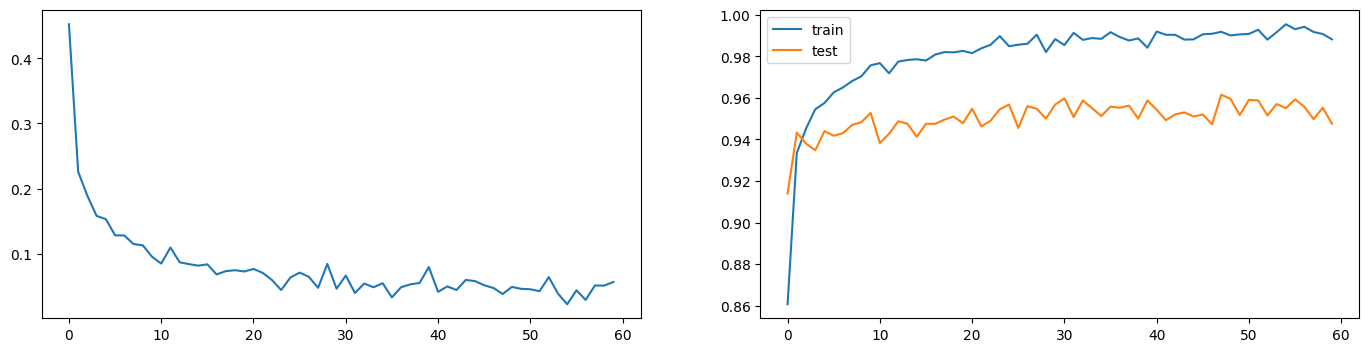

In [68]:
numepochs = 60
net, lossfun, optimizer = mnist_custom()
trainAcc,testAcc,lossTraining = training_2 (train_loader,test_loader, net,lossfun,optimizer,numepochs)

fig,ax = plt.subplots(1,2, figsize = (17,4))
ax[0].plot(lossTraining)

ax[1].plot(trainAcc)
ax[1].plot(testAcc)
ax[1].legend(["train","test"])

print("test accuracy :", testAcc[-1])


Text(0.5, 1.0, 'True number was 2. model predicted 5')

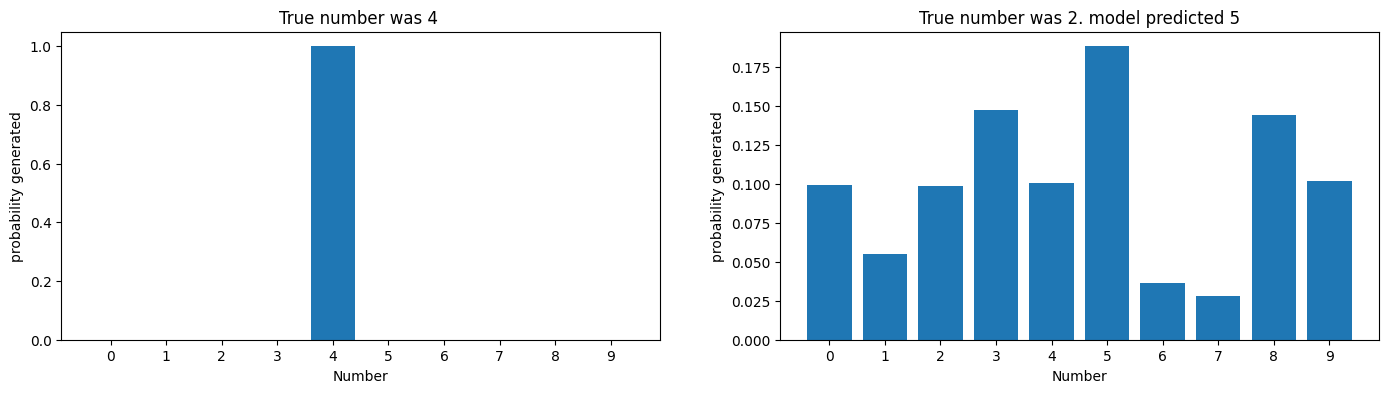

In [69]:
x,y = next(iter(test_loader))
pred = net(x).detach()

#finding errors
errors = np.where(torch.max(pred, axis = 1)[1]!=y)[0]

fig,ax = plt.subplots(1,2,figsize = (17,4))
sample2show = 120
ax[0].bar(range(10),torch.exp(pred[sample2show]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel("Number")
ax[0].set_ylabel("probability generated")
ax[0].set_title("True number was %s "%y[sample2show].item())

sample2show = 4
ax[1].bar(range(10),torch.exp(pred[errors[sample2show]]))
ax[1].set_xticks(range(10))
ax[1].set_xlabel("Number")
ax[1].set_ylabel("probability generated")
ax[1].set_title("True number was %s. model predicted %s"%(y[errors[sample2show]].item(),torch.argmax(pred[errors[sample2show]]).item()))

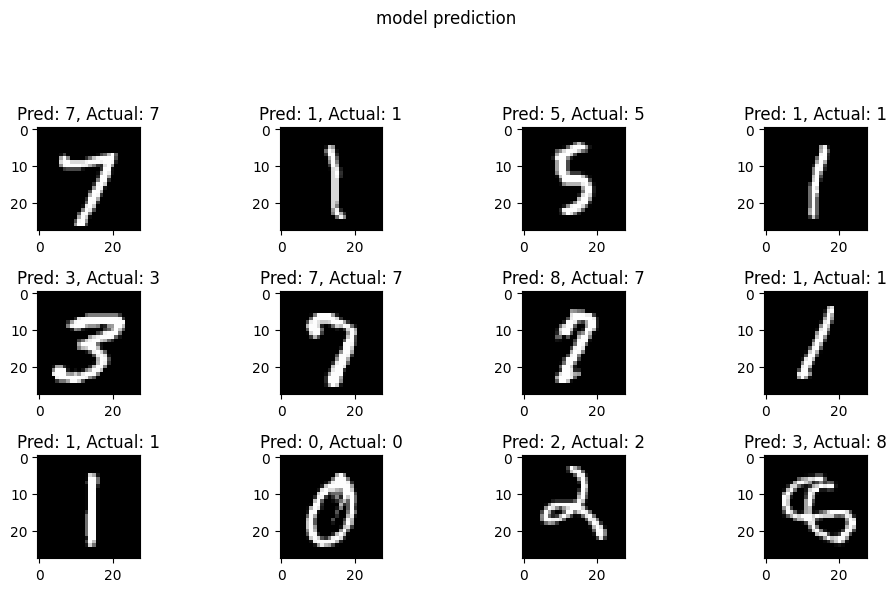

In [70]:

fig, axs = plt.subplots(3,4,figsize = (10,6))

for i,ax in enumerate(axs.flatten()):
  randimg = np.random.randint(0,high = 12)

  img = np.reshape(x[i,:],(28,28))
  ax.imshow(img,cmap = "gray")

  ax.set_title("Pred: %d, Actual: %d" % (torch.argmax(pred[i]).item(), y[i]))

plt.suptitle("model prediction",fontsize = 12)
plt.tight_layout(rect = [0,0,1,.9])

(array([10., 17., 29., 21., 35., 23., 13., 14., 27., 21.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

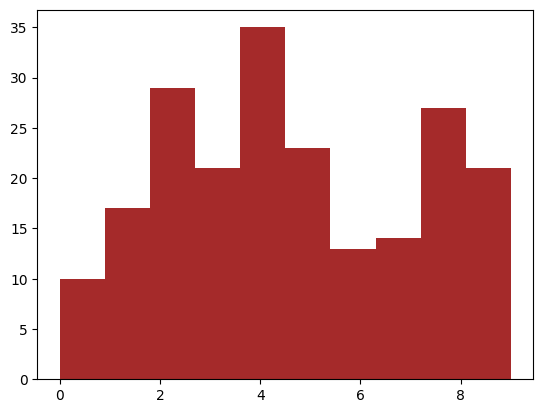

In [73]:
errors = np.where(torch.max(pred, axis = 1)[1]!=y)
plt.hist(y[errors],color = "brown")

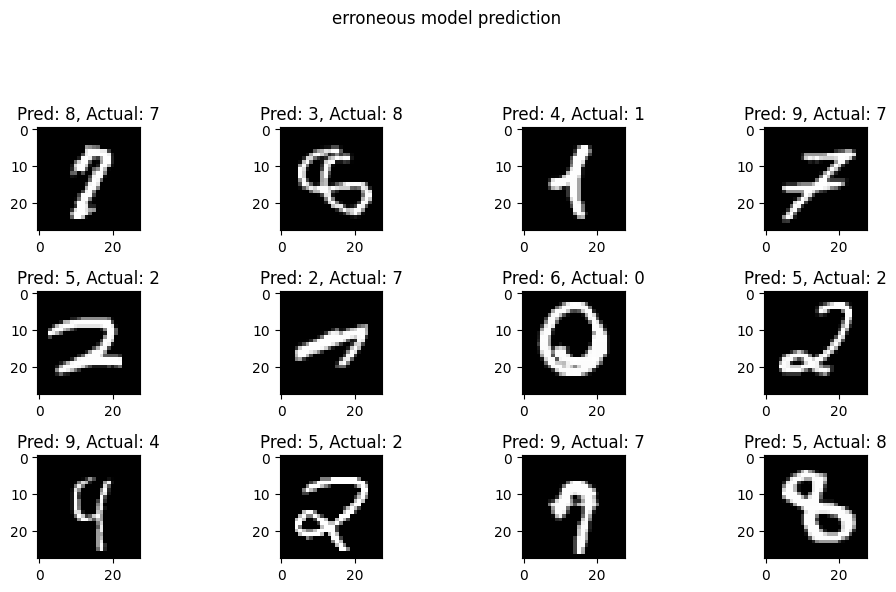

In [72]:
pred_err = pred[errors]
y_err = y[errors]
x_err = x[errors]
fig, axs = plt.subplots(3,4,figsize = (10,6))

for i,ax in enumerate(axs.flatten()):
  randimg = np.random.randint(0,high = 12)

  img = np.reshape(x_err[i,:],(28,28))
  ax.imshow(img,cmap = "gray")

  ax.set_title("Pred: %d, Actual: %d" % (torch.argmax(pred_err[i]).item(), y_err[i]))

plt.suptitle("erroneous model prediction",fontsize = 12)
plt.tight_layout(rect = [0,0,1,.9])

#Weight distributions

In [77]:
for i in net.named_parameters():
  print(i)

('input.weight', Parameter containing:
tensor([[ 0.0320,  0.0325,  0.0228,  ...,  0.0268, -0.0310, -0.0025],
        [ 0.0318, -0.0067, -0.0355,  ...,  0.0303,  0.0234, -0.0347],
        [-0.0102, -0.0240, -0.0212,  ..., -0.0120,  0.0104,  0.0050],
        ...,
        [ 0.0015,  0.0048, -0.0155,  ...,  0.0126,  0.0276, -0.0339],
        [-0.0270, -0.0296, -0.0354,  ..., -0.0034,  0.0065,  0.0236],
        [ 0.0033,  0.0071,  0.0223,  ...,  0.0147,  0.0152, -0.0029]],
       requires_grad=True))
('input.bias', Parameter containing:
tensor([-1.4148, -1.4928, -1.2500,  2.1771, -1.0894, -0.0292, -0.0257, -0.0456,
        -0.0441, -0.9047, -0.1020, -0.7809, -0.9240,  1.9168, -2.4770, -0.6084,
        -0.6128, -0.0056, -0.2666,  0.2429, -0.7457, -0.0304,  0.4769, -0.0601,
        -2.9100, -1.0656, -0.7823,  0.0222, -0.8827,  0.7985,  0.1588,  0.1436,
        -1.2994, -2.1212, -0.1201, -0.0576, -0.0798, -1.0579, -0.4574, -0.3819,
        -1.5399, -1.3490, -0.0509, -1.3877, -1.2413, -0.4692, 

In [80]:
net.input.weight.shape

torch.Size([64, 784])

In [81]:
net.input

Linear(in_features=784, out_features=64, bias=True)

In [82]:
vars(net.input)

{'training': True,
 '_parameters': {'weight': Parameter containing:
  tensor([[ 0.0320,  0.0325,  0.0228,  ...,  0.0268, -0.0310, -0.0025],
          [ 0.0318, -0.0067, -0.0355,  ...,  0.0303,  0.0234, -0.0347],
          [-0.0102, -0.0240, -0.0212,  ..., -0.0120,  0.0104,  0.0050],
          ...,
          [ 0.0015,  0.0048, -0.0155,  ...,  0.0126,  0.0276, -0.0339],
          [-0.0270, -0.0296, -0.0354,  ..., -0.0034,  0.0065,  0.0236],
          [ 0.0033,  0.0071,  0.0223,  ...,  0.0147,  0.0152, -0.0029]],
         requires_grad=True),
  'bias': Parameter containing:
  tensor([-1.4148, -1.4928, -1.2500,  2.1771, -1.0894, -0.0292, -0.0257, -0.0456,
          -0.0441, -0.9047, -0.1020, -0.7809, -0.9240,  1.9168, -2.4770, -0.6084,
          -0.6128, -0.0056, -0.2666,  0.2429, -0.7457, -0.0304,  0.4769, -0.0601,
          -2.9100, -1.0656, -0.7823,  0.0222, -0.8827,  0.7985,  0.1588,  0.1436,
          -1.2994, -2.1212, -0.1201, -0.0576, -0.0798, -1.0579, -0.4574, -0.3819,
          -1

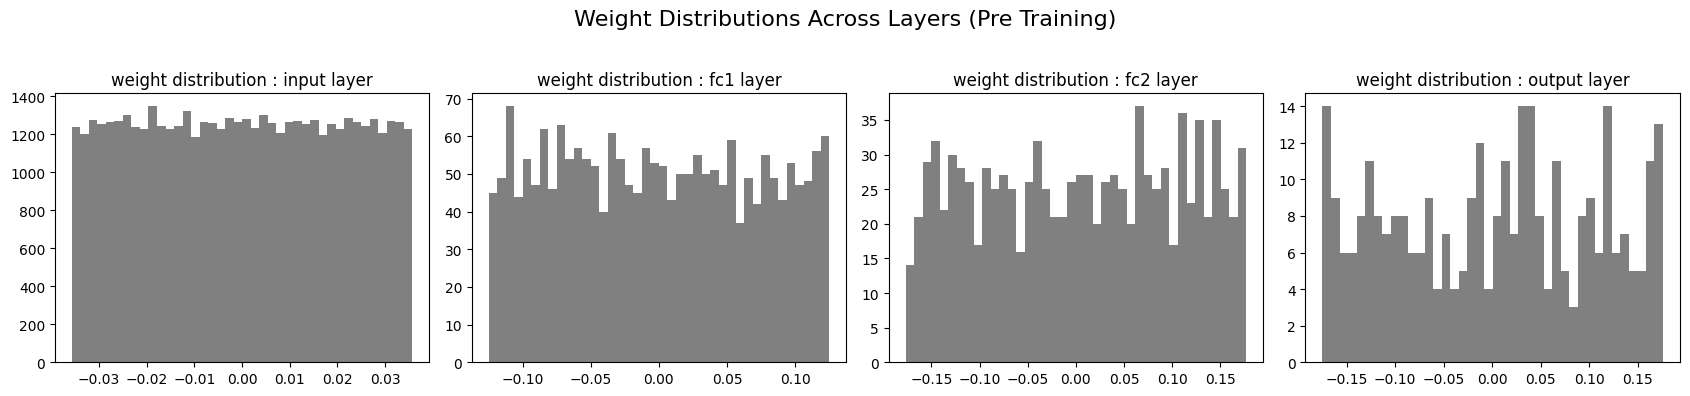

In [102]:
net0, lossfun, optimizer = mnist_custom()

fig,ax = plt.subplots(1,4,figsize = (17,4))
ax[0].hist(net0.input.weight.detach().flatten(),40,color = "grey")
ax[0].set_title("weight distribution : input layer")

ax[1].hist(net0.fc1.weight.detach().flatten(),40,color = "grey")
ax[1].set_title("weight distribution : fc1 layer")

ax[2].hist(net0.fc2.weight.detach().flatten(),40,color = "grey")
ax[2].set_title("weight distribution : fc2 layer")

ax[3].hist(net0.output.weight.detach().flatten(),40,color = "grey")
ax[3].set_title("weight distribution : output layer")

plt.suptitle("Weight Distributions Across Layers (Pre Training)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

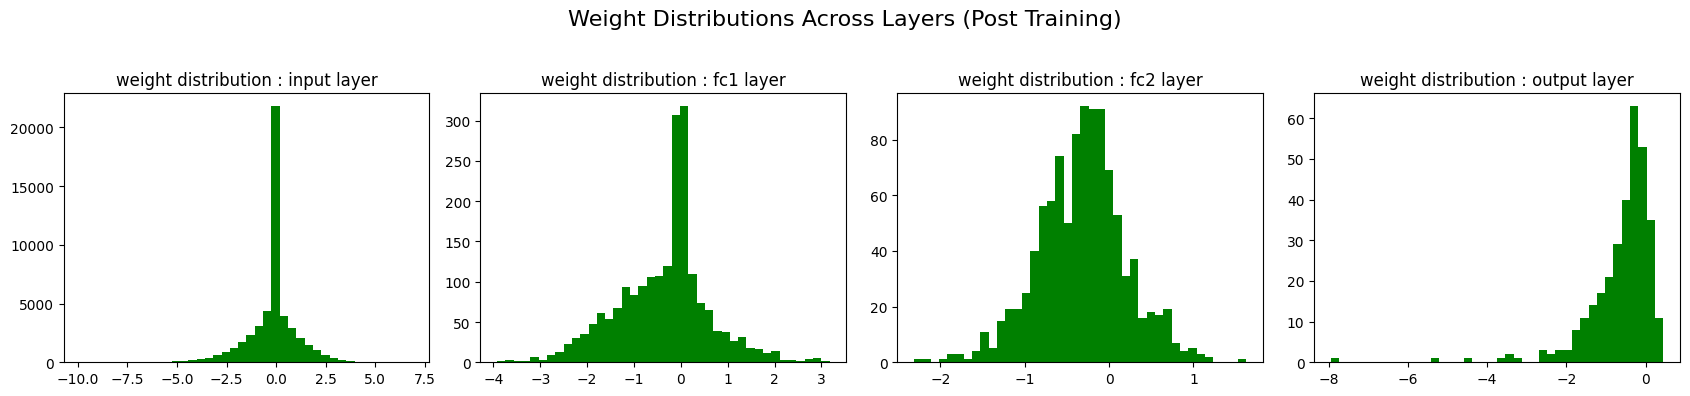

In [103]:
fig,ax = plt.subplots(1,4,figsize = (17,4))
ax[0].hist(net.input.weight.detach().flatten(),40,color = "green")
ax[0].set_title("weight distribution : input layer")

ax[1].hist(net.fc1.weight.detach().flatten(),40,color = "green")
ax[1].set_title("weight distribution : fc1 layer")

ax[2].hist(net.fc2.weight.detach().flatten(),40,color = "green")
ax[2].set_title("weight distribution : fc2 layer")

ax[3].hist(net.output.weight.detach().flatten(),40,color = "green")
ax[3].set_title("weight distribution : output layer")

plt.suptitle("Weight Distributions Across Layers (Post Training)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

#Image Scrambling

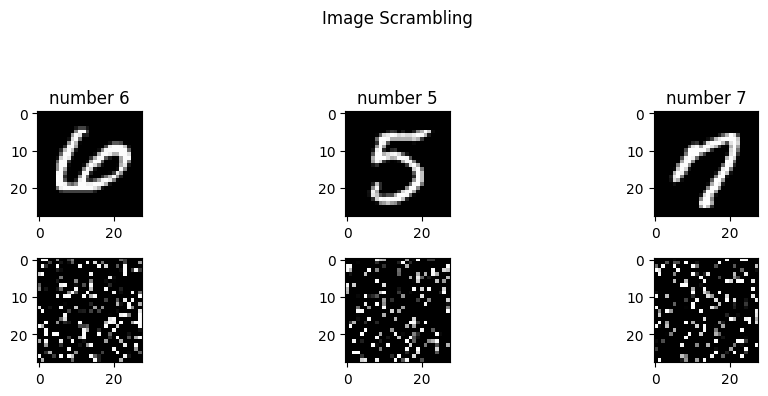

In [144]:
scramble_index = np.random.permutation(data.shape[1])
data_scrambled = dataNorm[:,scramble_index]

fig, axs = plt.subplots(2,3,figsize = (10,4))

for i in range(3):
  randimg = np.random.randint(0,high = 12)

  img = np.reshape(data_scrambled[i,:],(28,28))
  axs[1,i].imshow(img,cmap = "gray")

  img = np.reshape(dataNorm[i,:],(28,28))
  axs[0,i].imshow(img,cmap = "gray")
  axs[0,i].set_title(f"number {int(labels[i])}")

plt.suptitle("Image Scrambling",fontsize = 12)
plt.tight_layout(rect = [0,0,1,.9])

In [145]:
#train-test split
data_train, data_test, labels_train, labels_test = train_test_split(data_scrambled,labels, train_size=0.8)

#convert to tensor
data_train_tensor = torch.tensor(data_train).float()
data_test_tensor = torch.tensor(data_test).float()
labels_train_tensor = torch.tensor(labels_train).long() ## long = int64
labels_test_tensor = torch.tensor(labels_test).long() ## long = int64

print(data_train_tensor.shape)
print(labels_train_tensor.shape)

#tensor dataset
train_dataset = TensorDataset(data_train_tensor,labels_train_tensor)
test_dataset = TensorDataset(data_test_tensor,labels_test_tensor)

#dataloader
batchsize = 32
train_loader = DataLoader(train_dataset,batch_size = batchsize, shuffle = True,drop_last = True)
test_loader = DataLoader(test_dataset,batch_size = test_dataset.tensors[0].shape[0])

torch.Size([16000, 784])
torch.Size([16000])


test accuracy : 0.9512500166893005


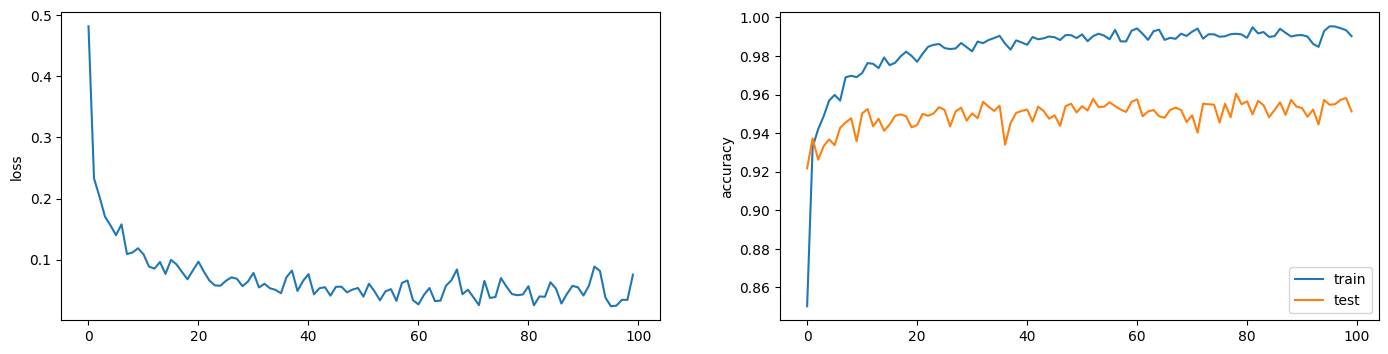

In [148]:
numepochs = 100
net_scrambled, lossfun, optimizer = mnist_custom()
trainAcc,testAcc,lossTraining = training_2 (train_loader,test_loader, net_scrambled,lossfun,optimizer,numepochs)

fig,ax = plt.subplots(1,2, figsize = (17,4))
ax[0].plot(lossTraining)
ax[0].set_ylabel("loss")

ax[1].plot(trainAcc)
ax[1].plot(testAcc)
ax[1].legend(["train","test"])
ax[1].set_ylabel("accuracy")

print("test accuracy :", testAcc[-1])

#Image Rolling (Shifting)

In [149]:
#train-test split
data_train, data_test, labels_train, labels_test = train_test_split(dataNorm,labels, train_size=0.8)

#convert to tensor
data_train_tensor = torch.tensor(data_train).float()
data_test_tensor = torch.tensor(data_test).float()
labels_train_tensor = torch.tensor(labels_train).long() ## long = int64
labels_test_tensor = torch.tensor(labels_test).long() ## long = int64

print(data_train_tensor.shape)
print(labels_train_tensor.shape)

#tensor dataset
train_dataset = TensorDataset(data_train_tensor,labels_train_tensor)
test_dataset = TensorDataset(data_test_tensor,labels_test_tensor)

#dataloader
batchsize = 32
train_loader = DataLoader(train_dataset,batch_size = batchsize, shuffle = True,drop_last = True)
test_loader = DataLoader(test_dataset,batch_size = test_dataset.tensors[0].shape[0])

torch.Size([16000, 784])
torch.Size([16000])


Text(0.5, 1.0, 'Rolled Down')

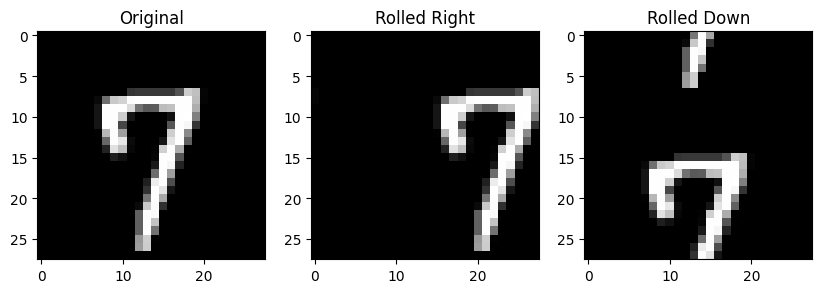

In [168]:
tmp = train_loader.dataset.tensors[0][0,:]
tmp = tmp.reshape(28,28)

#rolling the image (shifting)
tmpS = torch.roll(tmp,8,dims = 1)

fig,ax = plt.subplots(1,3,figsize = (10,3))
ax[0].imshow(tmp ,cmap = "grey")
ax[0].set_title("Original")

ax[1].imshow(tmpS ,cmap = "grey")
ax[1].set_title("Rolled Right")

tmpS = torch.roll(tmp,8,dims = 0)
ax[2].imshow(tmpS ,cmap = "grey")
ax[2].set_title("Rolled Down")

In [180]:
#shifting the test data
for i in range(test_loader.dataset.tensors[0].shape[0]):
  img = test_loader.dataset.tensors[0][i,:]

  randroll = np.random.randint(-10,11)
  img = torch.roll(img.reshape(28,28),randroll,dims = 1)

  test_loader.dataset.tensors[0][i,:] = img.reshape(1,-1)

test accuracy : 0.35074999928474426


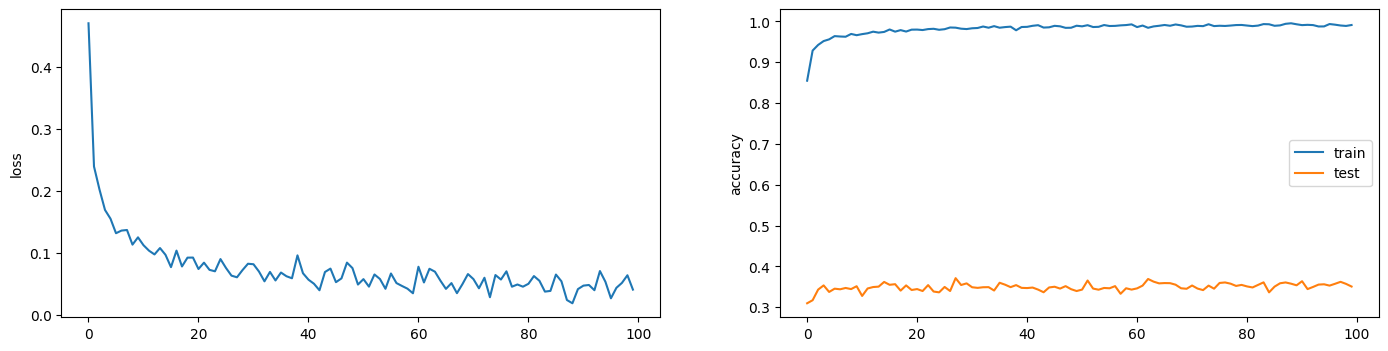

In [182]:
numepochs = 100
net_rolled, lossfun, optimizer = mnist_custom()
trainAcc,testAcc,lossTraining = training_2 (train_loader,test_loader, net_rolled,lossfun,optimizer,numepochs)

fig,ax = plt.subplots(1,2, figsize = (17,4))
ax[0].plot(lossTraining)
ax[0].set_ylabel("loss")

ax[1].plot(trainAcc)
ax[1].plot(testAcc)
ax[1].legend(["train","test"])
ax[1].set_ylabel("accuracy")

print("test accuracy :", testAcc[-1])

#Summary

*  **Softmax and Log-softmax** : Log-softmax stretches out penalties for incorrect guesses, which can improve category separability and increase numerical stability. Linear soft max works well for small number of categories, for larger number of categories log-softmax is preferred. However when classifying, its always best to test both approaches i.e. softmax, log-softmax and decide which works better.

*  **Image Scrambling**: Since feed forward networks do not use spatial information, scrambing columns does not impact the models accuracy. This however is not the case with CNNs which greatly leverage the spatial structure in an image.

*  **Image Rolling**: A shortcoming of FNNs are their imability to deal with image rolling.

*  **Universal approximation theorem**: A sufficiently wide or deep network can approximate any possible function. https://en.wikipedia.org/wiki/Universal_approximation_theorem







